# MALLORN TDE Classification - Random Forest Model (v2)

Train Random Forest với:
- Hyperparameter tuning với GridSearchCV
- Class imbalance handling (class_weight='balanced')
- Threshold optimization cho F1 score
- Feature importance analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             confusion_matrix, classification_report, roc_auc_score)
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

## Tải Features

In [4]:
train_features = pd.read_csv('train_features.csv')
test_features = pd.read_csv('test_features.csv')

print(f"Training samples: {len(train_features)}")
print(f"Test samples: {len(test_features)}")
print(f"TDE ratio: {train_features['target'].mean():.4f}")
print(f"Number of features: {len(train_features.columns) - 2}")

Training samples: 3043
Test samples: 7135
TDE ratio: 0.0486
Number of features: 294


## Chuẩn bị Dữ liệu

In [5]:
exclude_cols = ['object_id', 'target', 'Z_err', 'z_relative_err']
feature_cols = [c for c in train_features.columns if c not in exclude_cols]

X = train_features[feature_cols].values
y = train_features['target'].values

for col in feature_cols:
    if col not in test_features.columns:
        test_features[col] = 0

X_test = test_features[feature_cols].values

print(f"Feature matrix shape: {X.shape}")
print(f"Test matrix shape: {X_test.shape}")
print(f"Number of features: {len(feature_cols)}")

Feature matrix shape: (3043, 294)
Test matrix shape: (7135, 294)
Number of features: 294


## Scaling Features

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

print("Features scaled with StandardScaler")

Features scaled with StandardScaler


## Phân phối Class

In [7]:
n_neg = np.sum(y == 0)
n_pos = np.sum(y == 1)
imbalance_ratio = n_neg / n_pos

print(f"\nClass distribution:")
print(f"  Non-TDE (0): {n_neg} ({100*n_neg/len(y):.1f}%)")
print(f"  TDE (1): {n_pos} ({100*n_pos/len(y):.1f}%)")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"\nUsing class_weight='balanced' to handle imbalance")


Class distribution:
  Non-TDE (0): 2895 (95.1%)
  TDE (1): 148 (4.9%)
  Imbalance ratio: 19.56:1

Using class_weight='balanced' to handle imbalance


## Tìm kiếm Hyperparameter của Random Forest

In [8]:
print("="*60)
print("Hyperparameter search with GridSearchCV...")
print("="*60)

param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

base_rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

total_combinations = (len(param_grid['n_estimators']) * 
                     len(param_grid['max_depth']) * 
                     len(param_grid['min_samples_split']) * 
                     len(param_grid['min_samples_leaf']) *
                     len(param_grid['max_features']))
print(f"Testing {total_combinations} parameter combinations...")
print("This may take several minutes...\n")

Hyperparameter search with GridSearchCV...
Testing 216 parameter combinations...
This may take several minutes...



In [9]:
grid_search = GridSearchCV(
    estimator=base_rf,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

grid_search.fit(X_scaled, y)

print(f"\nBest CV F1 Score: {grid_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best CV F1 Score: 0.4652

Best Parameters:
  max_depth: 10
  max_features: sqrt
  min_samples_leaf: 4
  min_samples_split: 2
  n_estimators: 500


In [10]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')

print("\nTop 10 parameter combinations:")
top_cols = ['rank_test_score', 'mean_test_score', 'std_test_score', 
            'param_n_estimators', 'param_max_depth', 'param_min_samples_split',
            'param_min_samples_leaf', 'param_max_features']
print(results_df[top_cols].head(10).to_string(index=False))

results_df.to_csv('hyperparam_search_results.csv', index=False)


Top 10 parameter combinations:
 rank_test_score  mean_test_score  std_test_score  param_n_estimators param_max_depth  param_min_samples_split  param_min_samples_leaf param_max_features
               1         0.465222        0.085154                 500              10                        2                       4               sqrt
               1         0.465222        0.085154                 500              10                        5                       4               sqrt
               3         0.464889        0.094102                 300              10                        5                       1               sqrt
               4         0.462182        0.103604                 500              10                        5                       1               sqrt
               5         0.461934        0.093111                 200              10                        5                       2               sqrt
               6         0.458744        0.0

## Train Model Cuối với Parameters Tốt Nhất

In [11]:
print("\n" + "="*60)
print("Training final Random Forest model...")
print("="*60)

best_params = grid_search.best_params_.copy()
best_params['class_weight'] = 'balanced'
best_params['random_state'] = 42
best_params['n_jobs'] = -1
best_params['oob_score'] = True

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_scaled, y)

print(f"\nFinal model trained!")
print(f"  Number of trees: {final_model.n_estimators}")
print(f"  Max depth: {final_model.max_depth}")
print(f"  Number of features: {final_model.n_features_in_}")
print(f"  OOB Score: {final_model.oob_score_:.4f}")


Training final Random Forest model...

Final model trained!
  Number of trees: 500
  Max depth: 10
  Number of features: 294
  OOB Score: 0.9566


## Đánh giá Cross-Validation

In [12]:
print("\nPerforming full cross-validation evaluation...")

cv_proba = cross_val_predict(final_model, X_scaled, y, cv=cv, method='predict_proba')[:, 1]
cv_preds_default = (cv_proba >= 0.5).astype(int)

print(f"\nCV Results (default threshold=0.5):")
print(f"  F1 Score: {f1_score(y, cv_preds_default):.4f}")
print(f"  Precision: {precision_score(y, cv_preds_default):.4f}")
print(f"  Recall: {recall_score(y, cv_preds_default):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y, cv_proba):.4f}")


Performing full cross-validation evaluation...

CV Results (default threshold=0.5):
  F1 Score: 0.4711
  Precision: 0.6064
  Recall: 0.3851
  ROC-AUC: 0.9377


## Tối ưu Threshold

In [13]:
print("\n" + "="*60)
print("Optimizing threshold for maximum F1 score...")
print("="*60)

thresholds = np.arange(0.05, 0.95, 0.01)
f1_scores = []
precision_scores = []
recall_scores = []

for thresh in thresholds:
    preds = (cv_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y, preds))
    precision_scores.append(precision_score(y, preds, zero_division=0))
    recall_scores.append(recall_score(y, preds, zero_division=0))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1_optimized = f1_scores[best_idx]
best_precision = precision_scores[best_idx]
best_recall = recall_scores[best_idx]

print(f"\nOptimal threshold: {best_threshold:.3f}")
print(f"Best F1 Score: {best_f1_optimized:.4f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")


Optimizing threshold for maximum F1 score...

Optimal threshold: 0.330
Best F1 Score: 0.5079
Precision: 0.4174
Recall: 0.6486


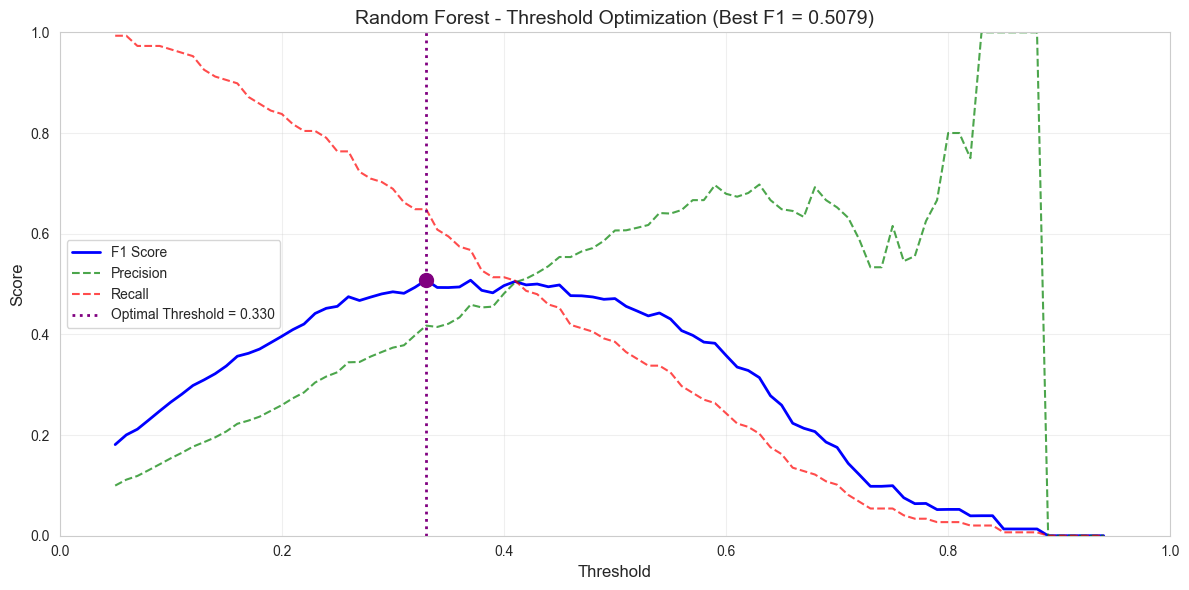

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(thresholds, f1_scores, 'b-', linewidth=2, label='F1 Score')
ax.plot(thresholds, precision_scores, 'g--', linewidth=1.5, alpha=0.7, label='Precision')
ax.plot(thresholds, recall_scores, 'r--', linewidth=1.5, alpha=0.7, label='Recall')
ax.axvline(best_threshold, color='purple', linestyle=':', linewidth=2, 
           label=f'Optimal Threshold = {best_threshold:.3f}')
ax.scatter([best_threshold], [best_f1_optimized], color='purple', s=100, zorder=5)

ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title(f'Random Forest - Threshold Optimization (Best F1 = {best_f1_optimized:.4f})', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

## Ma trận Nhầm lẫn


Classification Report (optimized threshold):
              precision    recall  f1-score   support

     Non-TDE       0.98      0.95      0.97      2895
         TDE       0.42      0.65      0.51       148

    accuracy                           0.94      3043
   macro avg       0.70      0.80      0.74      3043
weighted avg       0.95      0.94      0.95      3043



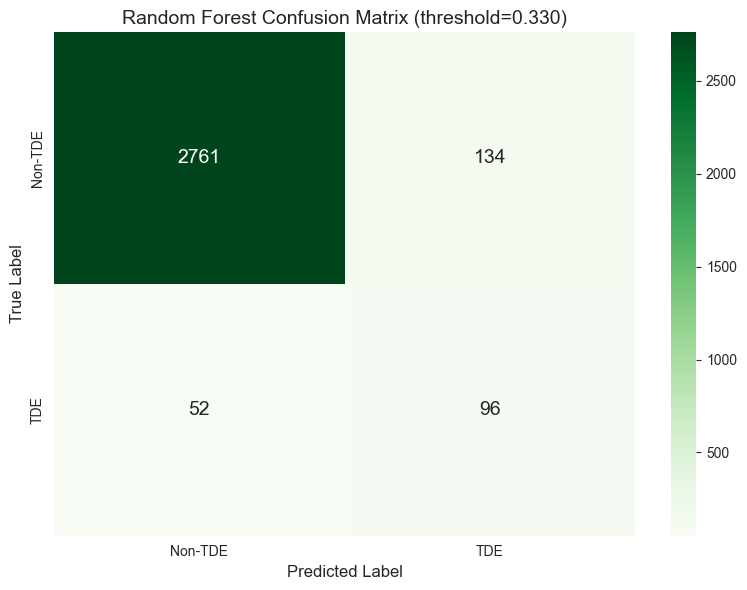


Confusion Matrix Details:
  True Negatives: 2761
  False Positives: 134
  False Negatives: 52
  True Positives: 96


In [15]:
best_preds = (cv_proba >= best_threshold).astype(int)
cm = confusion_matrix(y, best_preds)

print("\nClassification Report (optimized threshold):")
print(classification_report(y, best_preds, target_names=['Non-TDE', 'TDE']))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax,
            xticklabels=['Non-TDE', 'TDE'],
            yticklabels=['Non-TDE', 'TDE'],
            annot_kws={'size': 14})
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_title(f'Random Forest Confusion Matrix (threshold={best_threshold:.3f})', fontsize=14)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Details:")
print(f"  True Negatives: {tn}")
print(f"  False Positives: {fp}")
print(f"  False Negatives: {fn}")
print(f"  True Positives: {tp}")

## Phân tích Tầm quan trọng của Features


Top 30 Most Important Features:
          feature  importance
r_frac_above_mean    0.035297
      r_flux_skew    0.027697
       r_flux_p25    0.026954
      g_flux_skew    0.026089
 mean_variability    0.025981
             r_cv    0.025293
     r_decay_rate    0.021637
  max_variability    0.020395
     i_decay_rate    0.017729
      i_flux_skew    0.017639
      i_rise_time    0.016290
             i_cv    0.015316
      g_rise_time    0.015235
g_frac_above_mean    0.014900
      r_rise_time    0.014098
       g_flux_p10    0.013305
     r_snr_median    0.013214
       r_flux_p10    0.012783
             g_cv    0.012405
   r_det_duration    0.011861
       r_det_frac    0.011522
   i_det_duration    0.011236
  r_flux_kurtosis    0.010780
   g_det_duration    0.010635
      r_rise_rate    0.009967
       g_flux_p25    0.009710
    r_flux_median    0.009432
 peak_time_spread    0.009211
       i_flux_p10    0.009023
i_frac_above_mean    0.008392


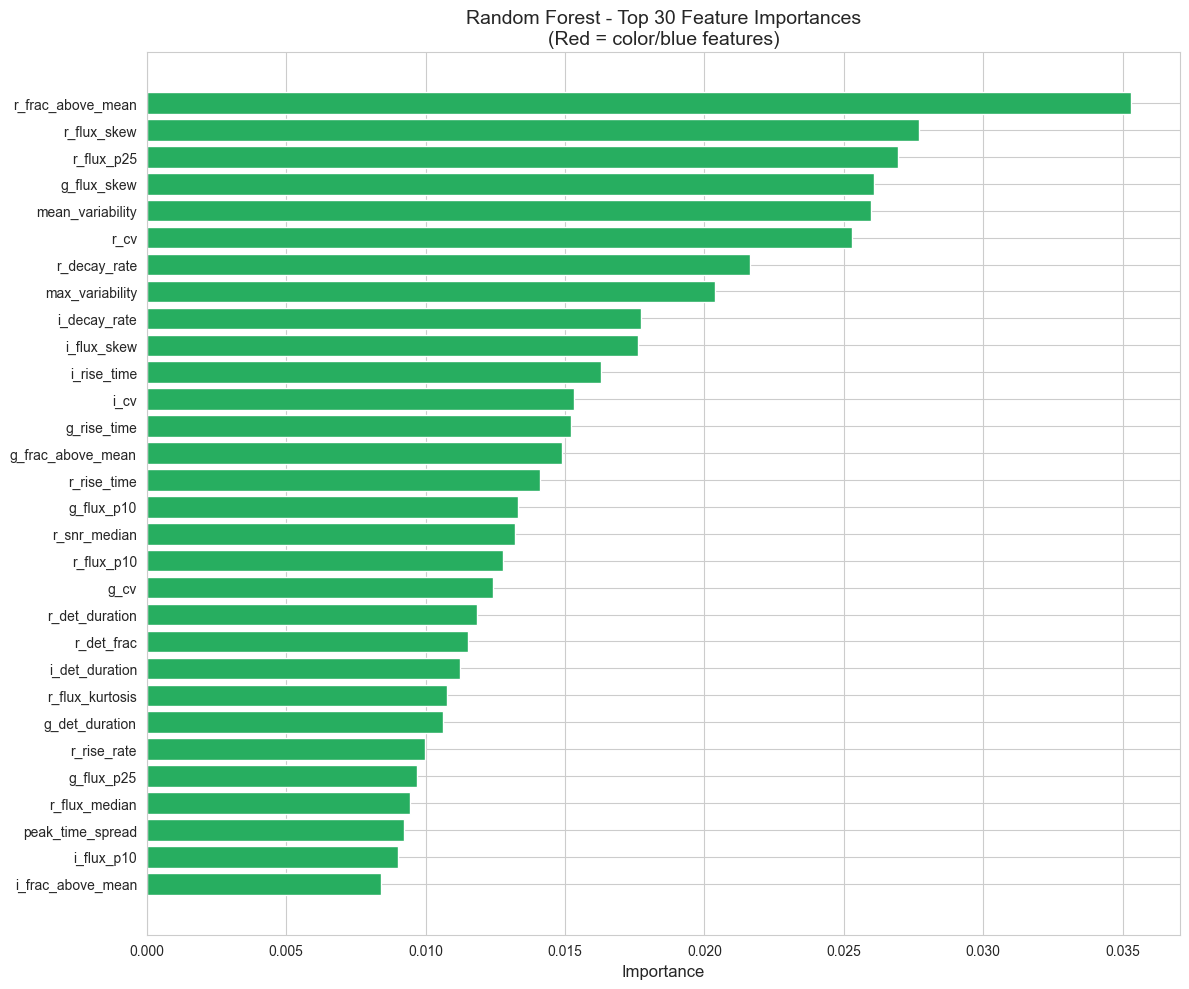

In [16]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 30 Most Important Features:")
print(feature_importance.head(30).to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 10))
top_n = 30
top_features = feature_importance.head(top_n)

colors = ['#e74c3c' if 'color' in f or 'blue' in f or 'u_' in f[:2] 
          else '#27ae60' for f in top_features['feature']]

ax.barh(range(len(top_features)), top_features['importance'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title(f'Random Forest - Top {top_n} Feature Importances\n(Red = color/blue features)', fontsize=14)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## Lưu Model và Các Artifacts

In [17]:
joblib.dump(final_model, 'rf_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

model_info = {
    'model_type': 'RandomForest',
    'best_threshold': best_threshold,
    'best_f1': best_f1_optimized,
    'best_precision': best_precision,
    'best_recall': best_recall,
    'roc_auc': roc_auc_score(y, cv_proba),
    'oob_score': final_model.oob_score_,
    'feature_cols': feature_cols,
    'best_params': best_params
}
joblib.dump(model_info, 'model_info.joblib')

feature_importance.to_csv('feature_importance.csv', index=False)

print("\n" + "="*60)
print("RANDOM FOREST MODEL TRAINING COMPLETE")
print("="*60)
print(f"\nBest Performance:")
print(f"  F1 Score: {best_f1_optimized:.4f}")
print(f"  Precision: {best_precision:.4f}")
print(f"  Recall: {best_recall:.4f}")
print(f"  ROC-AUC: {model_info['roc_auc']:.4f}")
print(f"  OOB Score: {final_model.oob_score_:.4f}")
print(f"  Optimal Threshold: {best_threshold:.3f}")
print(f"\nSaved files:")
print(f"  - rf_model.joblib")
print(f"  - scaler.joblib")
print(f"  - model_info.joblib")
print(f"  - feature_importance.csv")
print(f"  - hyperparam_search_results.csv")
print(f"\nNext: Run 03_prediction_submission.ipynb")
print("="*60)


RANDOM FOREST MODEL TRAINING COMPLETE

Best Performance:
  F1 Score: 0.5079
  Precision: 0.4174
  Recall: 0.6486
  ROC-AUC: 0.9377
  OOB Score: 0.9566
  Optimal Threshold: 0.330

Saved files:
  - rf_model.joblib
  - scaler.joblib
  - model_info.joblib
  - feature_importance.csv
  - hyperparam_search_results.csv

Next: Run 03_prediction_submission.ipynb
